# Threshold candidate detection (long paths in actual building interior)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import os
import glob

# Parameters
DATA_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\raw\b2"
OUTPUT_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\processed_buildings"
PEAK_Z = 0.3

# change this for every type!!
type_id = "b2"

In [2]:
def detect_threshold_candidates(z_scores, peak_z=1.2, min_idx=0, max_idx=None):
    if max_idx is None:
        max_idx = len(z_scores) - 1

    peaks = []

    for i in range(len(z_scores)):
        if z_scores[i] < peak_z:
            continue

        left2  = z_scores[i - 2] if i - 2 >= 0 else None
        left1  = z_scores[i - 1] if i - 1 >= 0 else None
        right1 = z_scores[i + 1] if i + 1 < len(z_scores) else None
        right2 = z_scores[i + 2] if i + 2 < len(z_scores) else None

        is_peak = True
        if left2 is not None and not (left2 < left1): is_peak = False
        if left1 is not None and not (left1 < z_scores[i]): is_peak = False
        if right1 is not None and not (z_scores[i] > right1): is_peak = False
        if right2 is not None and not (right1 > right2): is_peak = False

        if is_peak and min_idx <= i <= max_idx:
            peaks.append(i)

    return peaks


In [3]:
def calculate_isovist_features(isovist):
    """
    Calculate five isovist features from a given set of ray distances.
    """
    area = np.pi * np.sum(isovist) ** 2 / len(isovist)  # Approximate visible area as a circle
    perimeter = np.sum(isovist)
    occlusion = np.sum(isovist == 10.0) / len(isovist)
    variance = np.var(isovist)
    skewness = np.mean((isovist - np.mean(isovist))**3) / np.std(isovist)**3
    return [area, perimeter, occlusion, variance, skewness]


## visualize for the first path

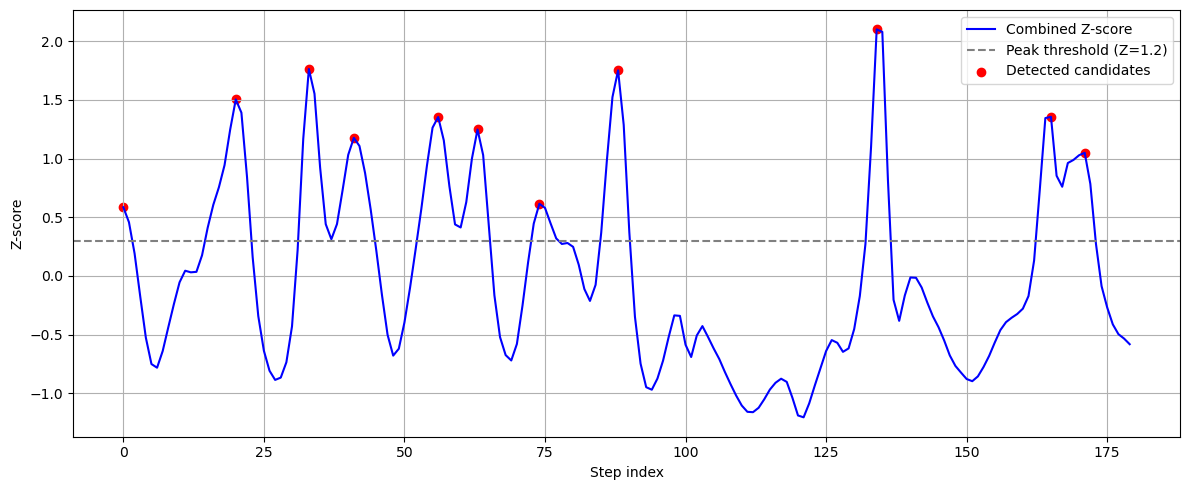

In [4]:
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "curve_*.csv")))
first_file = csv_files[0]
data = np.loadtxt(first_file, delimiter=",").T  # shape: (N, 2048)
n_points = data.shape[0]

# Ray-based differences
ray_diffs = np.linalg.norm(data[1:] - data[:-1], axis=1)
ray_z = (gaussian_filter1d(ray_diffs, sigma=1.0) - np.mean(ray_diffs)) / np.std(ray_diffs)

# Feature-based differences
features = np.array([calculate_isovist_features(iso) for iso in data])  # (N, 5)
feature_diffs = np.linalg.norm(features[1:] - features[:-1], axis=1)
feature_z = (gaussian_filter1d(feature_diffs, sigma=1.0) - np.mean(feature_diffs)) / np.std(feature_diffs)

# Combined Z-score
combined_z = 0.5 * ray_z + 0.5 * feature_z

# Detect candidates
candidates = detect_threshold_candidates(combined_z, PEAK_Z)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(combined_z, label="Combined Z-score", color='blue')
plt.axhline(PEAK_Z, color="gray", linestyle="--", label="Peak threshold (Z=1.2)")
plt.scatter(candidates, combined_z[candidates], color="red", label="Detected candidates")
plt.xlabel("Step index")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## detect threshold peaks

In [5]:
results = []
for file in csv_files:
    filename = os.path.basename(file)
    data = np.loadtxt(file, delimiter=",").T
    n = data.shape[0]
    diffs = np.linalg.norm(data[1:] - data[:-1], axis=1)
    z = (diffs - np.mean(diffs)) / np.std(diffs)
    candidates = detect_threshold_candidates(z, PEAK_Z)

    for c in candidates:
        results.append({
            "csv_file": filename,
            "candidate_idx": c
        })

df = pd.DataFrame(results)
df_path = os.path.join(OUTPUT_FOLDER, f"{type_id}_all_candidates_metadata.csv")
df.to_csv(df_path, index=False)
print(f"{len(df)} candidates from {len(csv_files)} paths")

9 candidates from 1 paths


## 7-frame windows

In [6]:
all_windows = []
for file in csv_files:
    filename = os.path.basename(file)
    path_id = os.path.splitext(filename)[0]
    data = np.loadtxt(file, delimiter=",").T
    n = data.shape[0]
    diffs = np.linalg.norm(data[1:] - data[:-1], axis=1)
    z = (diffs - np.mean(diffs)) / np.std(diffs)
    candidates = detect_threshold_candidates(z, PEAK_Z)

    for c in candidates:
        start = max(0, c - 3)
        end = min(n, c + 4)
        window = data[start:end]  # shape: (<=7, 2048)

        out_name = f"{type_id}_{path_id}_peak_{c:03d}.npy"
        out_path = os.path.join(OUTPUT_FOLDER, out_name)
        np.save(out_path, window)
        all_windows.append({
            "csv_file": filename,
            "candidate_idx": c,
            "start_idx": start,
            "end_idx": end,
            "window_file": out_name
        })

pd.DataFrame(all_windows).to_csv(df_path, index=False)
print(f"exported {len(all_windows)} .npy files")

exported 9 .npy files
